<a href="https://colab.research.google.com/github/smBello-tse/CIFAR10-classification/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import torch
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from time import time
root = '/kaggle/input'

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## **I. Data Pre-processing**



In [2]:
#Loading dataset
generator = torch.Generator().manual_seed(42)
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
val_test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
val_dataset, test_dataset = torch.utils.data.random_split(val_test_dataset, [0.5, 0.5], generator=generator)

100%|██████████| 170M/170M [00:07<00:00, 22.8MB/s]


Label is: 3
Image shape: torch.Size([3, 32, 32])


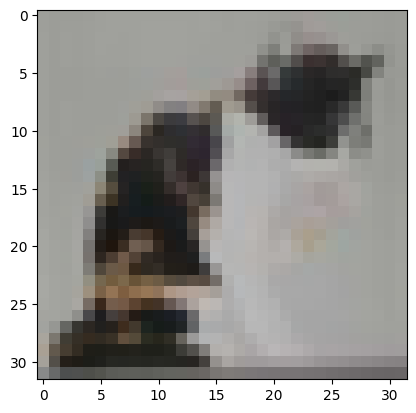

In [3]:
#Visualisation
image, target = train_dataset[785]
print(f"Label is: {target}")
print(f"Image shape: {image.shape}")
image = image.permute(1,2,0).numpy()
plt.imshow(image, cmap="gray")
plt.show()

In [4]:
#Creating dataloader
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=generator)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, generator=generator)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, generator=generator)


In [5]:
def compute_mean_std_dataset(dataset):
  imgs = [item[0] for item in train_dataset] # item[0] and item[1] are image and its label
  imgs = torch.stack(imgs, dim=0).numpy()

# calculate mean over each channel (r,g,b)
  mean_r = imgs[:,0,:,:].mean()
  mean_g = imgs[:,1,:,:].mean()
  mean_b = imgs[:,2,:,:].mean()
  means = (mean_r,mean_g,mean_b)

# calculate std over each channel (r,g,b)
  std_r = imgs[:,0,:,:].std()
  std_g = imgs[:,1,:,:].std()
  std_b = imgs[:,2,:,:].std()
  stds = (std_r,std_g,std_b)
  return means, stds

In [6]:
means_train, stds_train = compute_mean_std_dataset(train_dataset)
means_val, stds_val = compute_mean_std_dataset(val_dataset)
means_test, stds_test = compute_mean_std_dataset(test_dataset)
print(means_train, stds_train)
print(means_val, stds_val)
print(means_test, stds_test)

(np.float32(0.49139968), np.float32(0.48215827), np.float32(0.44653124)) (np.float32(0.24703233), np.float32(0.24348505), np.float32(0.26158768))
(np.float32(0.49139968), np.float32(0.48215827), np.float32(0.44653124)) (np.float32(0.24703233), np.float32(0.24348505), np.float32(0.26158768))
(np.float32(0.49139968), np.float32(0.48215827), np.float32(0.44653124)) (np.float32(0.24703233), np.float32(0.24348505), np.float32(0.26158768))


In [7]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(means_train, stds_train)])
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(means_val, stds_val)])
val_test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(means_test, stds_test)])
val_dataset, test_dataset = torch.utils.data.random_split(val_test_dataset, [0.5, 0.5], generator=generator)

In [8]:
means_train, stds_train = compute_mean_std_dataset(train_dataset)
means_val, stds_val = compute_mean_std_dataset(val_dataset)
means_test, stds_test = compute_mean_std_dataset(test_dataset)
print(means_train, stds_train)
print(means_val, stds_val)
print(means_test, stds_test)

(np.float32(6.749868e-08), np.float32(6.0572626e-07), np.float32(-1.1978435e-06)) (np.float32(0.99999994), np.float32(1.0000001), np.float32(1.000001))
(np.float32(6.749868e-08), np.float32(6.0572626e-07), np.float32(-1.1978435e-06)) (np.float32(0.99999994), np.float32(1.0000001), np.float32(1.000001))
(np.float32(6.749868e-08), np.float32(6.0572626e-07), np.float32(-1.1978435e-06)) (np.float32(0.99999994), np.float32(1.0000001), np.float32(1.000001))


# **II. Model implementation**

In [9]:
class Conv_layer(torch.nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=3, stride=None, padding=None):
    super().__init__()
    self.stride = 1 if stride is None else stride
    self.padding = 0 if padding is None else padding
    self.conv_layer = torch.nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, self.stride, self.padding),
                                          torch.nn.MaxPool2d(kernel_size=2),
                                          torch.nn.ReLu())


  def forward(self, x):
    return self.conv_layer(x)

In [10]:
x, _ = train_dataset[785]
x = x.unsqueeze(0)
conv_layer = Conv_layer(3, 16, 5)
feature_map = conv_layer(x)
print(feature_map.shape)

torch.Size([1, 16, 14, 14])


In [11]:
class My_CNN(torch.nn.Module):

  def __init__(self, in_channels, out_channels, conv_kernels, fc_dims):
    super().__init__()
    self.in_channels = in_channels
    self
    self.conv_kernels = conv_kernels
    self.fc_dims = fc_dims
    self.conv_layers = torch.nn.ModuleList([Conv_layer(cin, cout, kernel) for cin, cout, kernel in zip(in_channels, out_channels, conv_kernels)])
    self.fc_layers = torch.nn.ModuleList([torch.nn.Linear(dim_in, dim_out) for dim_in, dim_out in zip(fc_dims[:-1], fc_dims[1:])])

  def forward(self, x):
    for conv_layer in self.conv_layers:
      x = conv_layer(x)
    #print(f"x shape is {x.shape}")
    x = x.view(x.size(0), -1)
    for fc_layer in self.fc_layers:
      x = fc_layer(x)
    return x


# **III. Training and test**

In [12]:
image = train_dataset[785][0]
C, H, W = image.shape
nb_classes = 10
in_channels = (C, 16)
out_channels = (16, 32)
conv_kernels = (5, 5)
fc_dims = (out_channels[-1]*5*5, 128, nb_classes)
model = My_CNN(in_channels, out_channels, conv_kernels, fc_dims)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

My_CNN(
  (conv_layers): ModuleList(
    (0): Conv_layer(
      (conv_layer): Sequential(
        (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (2): ReLU()
      )
    )
    (1): Conv_layer(
      (conv_layer): Sequential(
        (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (2): ReLU()
      )
    )
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=800, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [13]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {num_params}")
print(f"Device is {device}")

Number of parameters: 117866
Device is cpu


In [14]:
if device=="cuda": model = torch.compile(model)

Epoch: 0


782it [00:35, 22.20it/s]
79it [00:02, 37.12it/s]


Loss_train: 1.8767 and loss_val: 1.6649
Epoch: 1


782it [00:35, 21.97it/s]
79it [00:02, 39.10it/s]


Loss_train: 1.6101 and loss_val: 1.5413
Epoch: 2


782it [00:35, 22.25it/s]
79it [00:02, 38.47it/s]


Loss_train: 1.5061 and loss_val: 1.4852
Epoch: 3


782it [00:35, 22.32it/s]
79it [00:02, 38.80it/s]


Loss_train: 1.4463 and loss_val: 1.4250
Epoch: 4


782it [00:35, 22.19it/s]
79it [00:02, 37.00it/s]


Loss_train: 1.4015 and loss_val: 1.3757
Epoch: 5


782it [00:34, 22.49it/s]
79it [00:02, 34.54it/s]


Loss_train: 1.3634 and loss_val: 1.3391
Epoch: 6


782it [00:34, 22.50it/s]
79it [00:02, 31.87it/s]


Loss_train: 1.3302 and loss_val: 1.3367
Epoch: 7


782it [00:34, 22.50it/s]
79it [00:02, 30.86it/s]


Loss_train: 1.3014 and loss_val: 1.2985
Epoch: 8


782it [00:34, 22.76it/s]
79it [00:02, 28.39it/s]


Loss_train: 1.2783 and loss_val: 1.2652
Epoch: 9


782it [00:34, 22.79it/s]
79it [00:02, 27.61it/s]


Loss_train: 1.2525 and loss_val: 1.2538
Epoch: 10


782it [00:35, 22.21it/s]
79it [00:02, 28.47it/s]


Loss_train: 1.2308 and loss_val: 1.2366
Epoch: 11


782it [00:36, 21.39it/s]
79it [00:02, 27.59it/s]


Loss_train: 1.2119 and loss_val: 1.2149
Epoch: 12


782it [00:34, 22.57it/s]
79it [00:02, 27.06it/s]


Loss_train: 1.1917 and loss_val: 1.2099
Epoch: 13


782it [00:34, 22.55it/s]
79it [00:02, 27.95it/s]


Loss_train: 1.1740 and loss_val: 1.1950
Epoch: 14


782it [00:34, 22.67it/s]
79it [00:02, 29.51it/s]


Loss_train: 1.1579 and loss_val: 1.1689
Epoch: 15


782it [00:34, 22.40it/s]
79it [00:02, 30.01it/s]


Loss_train: 1.1443 and loss_val: 1.1620
Epoch: 16


782it [00:34, 22.60it/s]
79it [00:02, 33.12it/s]


Loss_train: 1.1274 and loss_val: 1.1575
Epoch: 17


782it [00:35, 22.22it/s]
79it [00:02, 34.65it/s]


Loss_train: 1.1144 and loss_val: 1.1551
Epoch: 18


782it [00:36, 21.53it/s]
79it [00:02, 34.42it/s]


Loss_train: 1.1027 and loss_val: 1.1301
Epoch: 19


782it [00:35, 22.20it/s]
79it [00:02, 35.18it/s]


Loss_train: 1.0931 and loss_val: 1.1190
Epoch: 20


782it [00:35, 22.20it/s]
79it [00:02, 37.75it/s]


Loss_train: 1.0830 and loss_val: 1.1183
Epoch: 21


782it [00:35, 22.13it/s]
79it [00:02, 37.69it/s]


Loss_train: 1.0727 and loss_val: 1.1224
Epoch: 22


782it [00:35, 22.17it/s]
79it [00:02, 38.59it/s]


Loss_train: 1.0648 and loss_val: 1.1076
Epoch: 23


782it [00:35, 22.16it/s]
79it [00:02, 37.60it/s]


Loss_train: 1.0535 and loss_val: 1.0963
Epoch: 24


782it [00:35, 21.88it/s]
79it [00:02, 37.09it/s]


Loss_train: 1.0444 and loss_val: 1.0890
Epoch: 25


782it [00:35, 21.90it/s]
79it [00:02, 38.23it/s]


Loss_train: 1.0373 and loss_val: 1.0804
Epoch: 26


782it [00:36, 21.55it/s]
79it [00:02, 38.49it/s]


Loss_train: 1.0286 and loss_val: 1.0888
Epoch: 27


782it [00:35, 22.06it/s]
79it [00:02, 38.11it/s]


Loss_train: 1.0227 and loss_val: 1.0793
Epoch: 28


782it [00:35, 22.10it/s]
79it [00:02, 38.46it/s]


Loss_train: 1.0156 and loss_val: 1.0670
Epoch: 29


782it [00:35, 22.11it/s]
79it [00:02, 38.32it/s]


Loss_train: 1.0075 and loss_val: 1.0678
Epoch: 30


782it [00:35, 21.94it/s]
79it [00:02, 37.73it/s]


Loss_train: 1.0040 and loss_val: 1.0850
Epoch: 31


782it [00:35, 22.13it/s]
79it [00:02, 37.98it/s]


Loss_train: 0.9971 and loss_val: 1.0649
Epoch: 32


782it [00:35, 22.01it/s]
79it [00:02, 38.39it/s]


Loss_train: 0.9902 and loss_val: 1.0635
Epoch: 33


782it [00:35, 22.25it/s]
79it [00:02, 38.93it/s]


Loss_train: 0.9849 and loss_val: 1.0566
Epoch: 34


782it [00:36, 21.59it/s]
79it [00:02, 38.06it/s]


Loss_train: 0.9798 and loss_val: 1.0467
Epoch: 35


782it [00:35, 22.11it/s]
79it [00:02, 38.06it/s]


Loss_train: 0.9757 and loss_val: 1.0610
Epoch: 36


782it [00:35, 22.28it/s]
79it [00:02, 38.80it/s]


Loss_train: 0.9695 and loss_val: 1.0501
Epoch: 37


782it [00:35, 22.13it/s]
79it [00:02, 37.77it/s]


Loss_train: 0.9672 and loss_val: 1.0465
Epoch: 38


782it [00:35, 22.24it/s]
79it [00:02, 38.73it/s]


Loss_train: 0.9595 and loss_val: 1.0356
Epoch: 39


782it [00:35, 22.20it/s]
79it [00:02, 38.50it/s]


Loss_train: 0.9571 and loss_val: 1.0349
Epoch: 40


782it [00:35, 22.26it/s]
79it [00:02, 38.74it/s]


Loss_train: 0.9509 and loss_val: 1.0406
Epoch: 41


782it [00:35, 22.15it/s]
79it [00:02, 38.84it/s]


Loss_train: 0.9480 and loss_val: 1.0530
Epoch: 42


782it [00:36, 21.71it/s]
79it [00:02, 38.28it/s]


Loss_train: 0.9443 and loss_val: 1.0337
Epoch: 43


782it [00:35, 22.33it/s]
79it [00:02, 38.81it/s]


Loss_train: 0.9401 and loss_val: 1.0277
Epoch: 44


782it [00:34, 22.37it/s]
79it [00:02, 39.01it/s]


Loss_train: 0.9371 and loss_val: 1.0312
Epoch: 45


782it [00:35, 22.25it/s]
79it [00:02, 38.71it/s]


Loss_train: 0.9334 and loss_val: 1.0555
Epoch: 46


782it [00:35, 22.15it/s]
79it [00:02, 38.35it/s]


Loss_train: 0.9296 and loss_val: 1.0312
Epoch: 47


782it [00:34, 22.42it/s]
79it [00:02, 35.65it/s]


Loss_train: 0.9264 and loss_val: 1.0261
Epoch: 48


782it [00:34, 22.77it/s]
79it [00:02, 30.70it/s]


Loss_train: 0.9244 and loss_val: 1.0265
Epoch: 49


782it [00:34, 22.68it/s]
79it [00:02, 28.08it/s]


Loss_train: 0.9181 and loss_val: 1.0281
Epoch: 50


782it [00:35, 22.24it/s]
79it [00:02, 30.36it/s]


Loss_train: 0.9169 and loss_val: 1.0167
Epoch: 51


782it [00:34, 22.66it/s]
79it [00:02, 33.57it/s]


Loss_train: 0.9122 and loss_val: 1.0202
Epoch: 52


782it [00:34, 22.46it/s]
79it [00:02, 38.45it/s]


Loss_train: 0.9098 and loss_val: 1.0134
Epoch: 53


782it [00:35, 22.21it/s]
79it [00:02, 37.26it/s]


Loss_train: 0.9077 and loss_val: 1.0097
Epoch: 54


782it [00:35, 22.08it/s]
79it [00:02, 37.58it/s]


Loss_train: 0.9044 and loss_val: 1.0098
Epoch: 55


782it [00:35, 22.20it/s]
79it [00:02, 38.49it/s]


Loss_train: 0.9012 and loss_val: 1.0082
Epoch: 56


782it [00:35, 22.06it/s]
79it [00:02, 38.24it/s]


Loss_train: 0.8986 and loss_val: 1.0240
Epoch: 57


782it [00:35, 21.85it/s]
79it [00:02, 37.33it/s]


Loss_train: 0.8956 and loss_val: 1.0045
Epoch: 58


782it [00:36, 21.54it/s]
79it [00:02, 38.05it/s]


Loss_train: 0.8950 and loss_val: 1.0206
Epoch: 59


782it [00:35, 22.17it/s]
79it [00:02, 38.53it/s]


Loss_train: 0.8909 and loss_val: 1.0185
Epoch: 60


782it [00:35, 21.95it/s]
79it [00:02, 37.78it/s]


Loss_train: 0.8867 and loss_val: 1.0297
Epoch: 61


782it [00:35, 22.15it/s]
79it [00:02, 38.09it/s]


Loss_train: 0.8861 and loss_val: 1.0116
Epoch: 62


782it [00:39, 19.90it/s]
79it [00:02, 35.51it/s]


Loss_train: 0.8828 and loss_val: 1.0061
Epoch: 63


782it [00:35, 22.19it/s]
79it [00:02, 37.74it/s]


Loss_train: 0.8808 and loss_val: 1.0148
Epoch: 64


782it [00:35, 22.21it/s]
79it [00:02, 38.62it/s]


Loss_train: 0.8794 and loss_val: 1.0008
Epoch: 65


782it [00:35, 22.25it/s]
79it [00:02, 38.75it/s]


Loss_train: 0.8763 and loss_val: 1.0030
Epoch: 66


782it [00:34, 22.43it/s]
79it [00:02, 38.69it/s]


Loss_train: 0.8733 and loss_val: 1.0046
Epoch: 67


782it [00:36, 21.66it/s]
79it [00:02, 38.89it/s]


Loss_train: 0.8702 and loss_val: 1.0043
Epoch: 68


782it [00:34, 22.39it/s]
79it [00:02, 39.00it/s]


Loss_train: 0.8695 and loss_val: 1.0065
Epoch: 69


782it [00:35, 22.28it/s]
79it [00:02, 38.55it/s]


Loss_train: 0.8677 and loss_val: 1.0032
Epoch: 70


782it [00:35, 22.32it/s]
79it [00:02, 38.13it/s]


Loss_train: 0.8658 and loss_val: 0.9993
Epoch: 71


782it [00:35, 22.26it/s]
79it [00:02, 38.61it/s]


Loss_train: 0.8648 and loss_val: 1.0028
Epoch: 72


782it [00:35, 22.25it/s]
79it [00:02, 38.29it/s]


Loss_train: 0.8609 and loss_val: 1.0004
Epoch: 73


782it [00:35, 22.32it/s]
79it [00:02, 38.35it/s]


Loss_train: 0.8588 and loss_val: 0.9989
Epoch: 74


782it [00:34, 22.43it/s]
79it [00:02, 38.65it/s]


Loss_train: 0.8588 and loss_val: 0.9989
Epoch: 75


782it [00:35, 21.79it/s]
79it [00:02, 38.23it/s]


Loss_train: 0.8558 and loss_val: 1.0061
Epoch: 76


782it [00:34, 22.66it/s]
79it [00:02, 34.02it/s]


Loss_train: 0.8538 and loss_val: 1.0008
Epoch: 77


782it [00:34, 22.66it/s]
79it [00:02, 29.99it/s]


Loss_train: 0.8522 and loss_val: 0.9960
Epoch: 78


782it [00:34, 22.84it/s]
79it [00:02, 27.70it/s]


Loss_train: 0.8502 and loss_val: 0.9912
Epoch: 79


782it [00:33, 23.01it/s]
79it [00:02, 30.78it/s]


Loss_train: 0.8482 and loss_val: 1.0120
Epoch: 80


782it [00:34, 22.72it/s]
79it [00:02, 35.73it/s]


Loss_train: 0.8458 and loss_val: 0.9914
Epoch: 81


782it [00:34, 22.53it/s]
79it [00:02, 38.63it/s]


Loss_train: 0.8451 and loss_val: 0.9896
Epoch: 82


782it [00:35, 22.23it/s]
79it [00:02, 38.29it/s]


Loss_train: 0.8424 and loss_val: 0.9884
Epoch: 83


782it [00:35, 22.23it/s]
79it [00:02, 38.30it/s]


Loss_train: 0.8416 and loss_val: 0.9998
Epoch: 84


782it [00:36, 21.46it/s]
79it [00:02, 38.52it/s]


Loss_train: 0.8410 and loss_val: 0.9998
Epoch: 85


782it [00:34, 22.48it/s]
79it [00:02, 38.87it/s]


Loss_train: 0.8384 and loss_val: 0.9966
Epoch: 86


782it [00:35, 22.31it/s]
79it [00:02, 38.01it/s]


Loss_train: 0.8360 and loss_val: 1.0111
Epoch: 87


782it [00:35, 22.22it/s]
79it [00:02, 38.58it/s]


Loss_train: 0.8353 and loss_val: 1.0016
Epoch: 88


782it [00:34, 22.39it/s]
79it [00:02, 39.21it/s]


Loss_train: 0.8328 and loss_val: 0.9860
Epoch: 89


782it [00:34, 22.48it/s]
79it [00:02, 38.78it/s]


Loss_train: 0.8335 and loss_val: 0.9863
Epoch: 90


782it [00:34, 22.40it/s]
79it [00:02, 38.90it/s]


Loss_train: 0.8302 and loss_val: 0.9892
Epoch: 91


782it [00:34, 22.42it/s]
79it [00:02, 37.02it/s]


Loss_train: 0.8290 and loss_val: 0.9973
Epoch: 92


782it [00:35, 21.80it/s]
79it [00:02, 38.96it/s]


Loss_train: 0.8277 and loss_val: 0.9867
Epoch: 93


782it [00:34, 22.55it/s]
79it [00:02, 34.02it/s]


Loss_train: 0.8272 and loss_val: 0.9896
Epoch: 94


782it [00:34, 22.71it/s]
79it [00:02, 29.95it/s]


Loss_train: 0.8249 and loss_val: 0.9873
Epoch: 95


782it [00:34, 22.93it/s]
79it [00:02, 27.44it/s]


Loss_train: 0.8234 and loss_val: 0.9806
Epoch: 96


782it [00:34, 22.92it/s]
79it [00:02, 31.46it/s]


Loss_train: 0.8217 and loss_val: 0.9824
Epoch: 97


782it [00:34, 22.63it/s]
79it [00:02, 35.69it/s]


Loss_train: 0.8211 and loss_val: 0.9865
Epoch: 98


782it [00:34, 22.56it/s]
79it [00:02, 38.19it/s]


Loss_train: 0.8203 and loss_val: 0.9893
Epoch: 99


782it [00:34, 22.37it/s]
79it [00:02, 37.89it/s]


Loss_train: 0.8195 and loss_val: 0.9823
Time elapsed: 37.04991436004639
Seconds per epoch: 0.3704991436004639
Best epoch: 99


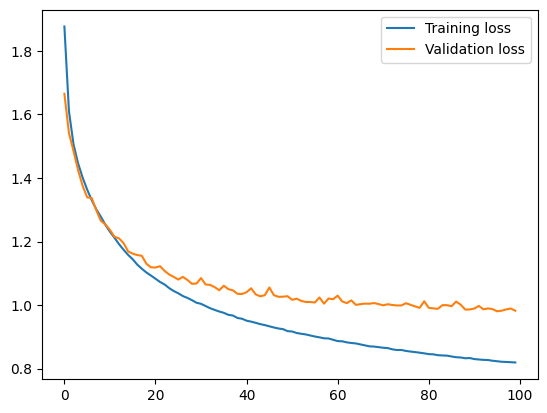

In [15]:
#Training and validation
nb_epochs = 100
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
criterion = torch.nn.CrossEntropyLoss()
losses_train, losses_val = [], []
best_loss = 1e5
lr_decay = 0.99
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, lr_decay)
torch.set_float32_matmul_precision('high')

model.train()

for epoch in range(nb_epochs):
  start = time()
  print(f"Epoch: {epoch}")
  #print("Now training...")
  loss_train, loss_val = 0, 0
  for idx, (batch, target) in tqdm(enumerate(train_loader)):
    batch, target = batch.to(device), target.to(device)
    optimizer.zero_grad()
    #with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
    preds = model(batch)
    #print(preds.shape, preds.dtype)
    #print(target.shape, target.dtype)
    loss = criterion(preds, target)
    loss.backward()
    loss_train += loss.item()
    optimizer.step()
  loss_train /= len(train_loader)
  losses_train.append(loss_train)
  scheduler.step()


  #print("Now validation...")
  with torch.no_grad():
    for idx, (batch, target) in tqdm(enumerate(val_loader)):
      batch, target = batch.to(device), target.to(device)
      preds = model(batch)
      #print(preds.shape, preds.dtype)
      #print(target.shape, target.dtype)
      loss = criterion(preds, target)
      loss_val += loss.item()
      if loss.item() < best_loss:
          best_loss = loss.item()
          best_model, best_epoch = model, epoch
    loss_val /= len(test_loader)
    losses_val.append(loss_val)

  print(f"Loss_train: {loss_train:.4f} and loss_val: {loss_val:.4f}")
end = time()
time_elapsed = end- start
print(f"Time elapsed: {time_elapsed}")
print(f"Seconds per epoch: {time_elapsed / nb_epochs}")
print(f"Best epoch: {epoch}")

epochs = range(nb_epochs)
plt.plot(epochs, losses_train, label="Training loss")
plt.plot(epochs, losses_val, label="Validation loss")
plt.legend()
plt.show()

In [16]:
#Test
best_model.eval()
print("Now testing...")
loss_test = 0
test_batch = next(iter(test_loader))
all_preds = []
all_targets = []
with torch.no_grad():
  for idx, (batch, target) in tqdm(enumerate(test_loader)):
      batch, target = batch.to(device), target.to(device)
      preds = best_model(batch)
      loss = criterion(preds, target)
      loss_test += loss.item()
      all_preds.append(torch.argmax(preds, dim=-1).cpu().numpy())
      all_targets.append(target.cpu().numpy())
  all_preds = np.concatenate(all_preds)
  all_targets = np.concatenate(all_targets)
  loss_test /= len(test_loader)

  print(f"Loss_test: {loss_test:.4f}")




Now testing...


79it [00:02, 32.51it/s]

Loss_test: 0.9759


<Axes: >

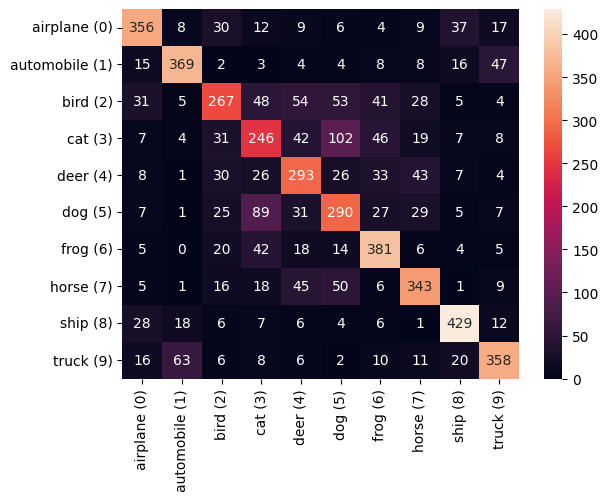

In [17]:
labels = ["airplane (0)", "automobile (1)", "bird (2)", "cat (3)", "deer (4)", "dog (5)", "frog (6)", "horse (7)", "ship (8)", "truck (9)"]
#
cm = confusion_matrix(all_targets, all_preds, labels=range(10))
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(cm_df, annot=True, fmt="d")

In [18]:
print(f"Accuracy score is: {accuracy_score(all_targets, all_preds)}")

Accuracy score is: 0.6664


In [19]:
def accuracy_multi_class(y_true, y_pred, cm):
  '''
  y_true: true labels
  y_pred: predicted labels
  cm: confusion matrix

  return list of accuracies for each classes
  '''
  accuracies = np.zeros((cm.shape[0],))
  for i in range(cm.shape[0]):
    accuracies[i] = cm[i,i] / np.sum(cm[i,:])
  return accuracies

accuracies = accuracy_multi_class(all_targets, all_preds, cm)
accuracies_df = pd.DataFrame(accuracies, index=labels, columns=["Accuracy"])
accuracies_df = accuracies_df.sort_values(by="Accuracy", ascending=False)
print(accuracies_df)


                Accuracy
ship (8)        0.829787
automobile (1)  0.775210
frog (6)        0.769697
airplane (0)    0.729508
truck (9)       0.716000
horse (7)       0.694332
deer (4)        0.622081
dog (5)         0.567515
bird (2)        0.498134
cat (3)         0.480469
